## I. Setup & Data Loading

In [1]:
# Install required packages
%pip install scikit-learn lightgbm matplotlib seaborn shap --quiet

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.2 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\VTC\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Import libraries and load bearing features
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import shap

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)
print("Libraries imported successfully")

BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
PROCESSED_DIR = BASE_DIR / "converted_data/processed"
FEATURES_DIR = BASE_DIR / "data/features"
MODELS_DIR = BASE_DIR / "models"
METRICS_DIR = MODELS_DIR / "metrics/bearing"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

bearing_file = FEATURES_DIR / "bearing_features.csv"
print(f"Loading bearing features from: {bearing_file}")
df = pd.read_csv(bearing_file)

Libraries imported successfully


In [5]:
# Define paths
BASE_DIR = Path.cwd().parent.parent if Path.cwd().name == 'notebooks' else Path.cwd()
PROCESSED_DIR = BASE_DIR / "converted_data/processed"
FEATURES_DIR = BASE_DIR / "supplement_data/features"
MODELS_DIR = BASE_DIR / "models/saved_models/bearing"
METRICS_DIR = BASE_DIR / "models/metrics/bearing"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Models will be saved to: {MODELS_DIR}")

Base directory: d:\Final BA2
Models will be saved to: d:\Final BA2\models\saved_models\bearing


In [22]:
# Load bearing data
bearing_file = PROCESSED_DIR / "bearing_features_all.csv"

if not bearing_file.exists():
    print(f"File not found: {bearing_file}")
    print("Please run bearing_pipeline.py first to generate processed data.")
else:
    df = pd.read_csv(bearing_file)
    print(f"Loaded bearing data: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
    
    print(f"\n Data Summary:")
    print(f"  Total samples: {len(df):,}")
    print(f"  Features: {len(df.columns) - 3}")
    if 'fault_type' in df.columns:
        print(f"\n  Fault types:")
        print(df['fault_type'].value_counts())

Loaded bearing data: (2993, 10)

Columns: ['start_sample', 'window_length', 'rms', 'peak', 'peak_to_peak', 'kurtosis', 'crest_factor', 'fault_type', 'load', 'source_file']

First few rows:


,start_sample,window_length,rms,peak,peak_to_peak,kurtosis,crest_factor,fault_type,load,source_file
0,0,2048,0.134602,0.481783,0.934489,2.901972,3.579324,B007,0,B007_0_features
1,2048,2048,0.139796,0.509072,1.003687,3.078723,3.641542,B007,0,B007_0_features
2,4096,2048,0.133587,0.432240,0.847424,2.602795,3.235633,B007,0,B007_0_features
3,6144,2048,0.140045,0.520442,0.977210,3.097466,3.716252,B007,0,B007_0_features
4,8192,2048,0.141407,0.487630,0.917758,2.864813,3.448413,B007,0,B007_0_features



 Data Summary:
  Total samples: 2,993
  Features: 7

  Fault types:
fault_type
Normal    832
IR007     241
B014      240
B007      240
IR014     240
B021      240
IR021     240
OR0076    240
OR0146    240
OR0216    240
Name: count, dtype: int64


## II. Baseline - Rule-Based Anomaly Detection

Current approach from `bearing_pipeline.py`:
- Health Index = f(RMS, Kurtosis)
- Anomaly if: health_index < 0.5 OR kurtosis > 5.0

In [ ]:
# Feature columns for modeling (exclude metadata)
# NOTE: Exploratory plots live in Multi_Equipment_EDA.ipynb
feature_cols = [col for col in df.columns if col not in ['equipment_id', 'fault_type', 'load', 'source_file']]

print(f"Selected {len(feature_cols)} features for modeling:")
print(feature_cols)

Selected 7 features for modeling:
['start_sample', 'window_length', 'rms', 'peak', 'peak_to_peak', 'kurtosis', 'crest_factor']


## III. Machine Learning Approach - Isolation Forest

Unsupervised anomaly detection using Isolation Forest:
- Learns feature interactions automatically
- Adaptive anomaly scoring
- No need for failure labels

In [ ]:
# Prepare modeling dataset
# (EDA visualizations moved to Multi_Equipment_EDA.ipynb)
X = df[feature_cols].copy()

print(f"Modeling dataset shape: {X.shape}")
print(f"Preview columns: {X.columns.tolist()}")

Missing values: 0

✅ Features prepared: (2993, 7)
   Scaled to mean=0, std=1


In [ ]:
# Train/test split
# (no exploratory visuals here)
train_ratio = 0.8
val_ratio = 0.2
sample_size = len(X)
split_index = int(sample_size * train_ratio)
X_sample = X.sample(frac=1, random_state=42)
X_train = X_sample.iloc[:split_index]
X_val = X_sample.iloc[split_index:]

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")

                  ISOLATION FOREST TRAINING

[Contamination = 10%]
  Anomaly rate: 10.0%
  Detected: 300 anomalies

[Contamination = 15%]
  Anomaly rate: 10.0%
  Detected: 300 anomalies

[Contamination = 15%]
  Anomaly rate: 15.0%
  Detected: 449 anomalies

[Contamination = 20%]
  Anomaly rate: 15.0%
  Detected: 449 anomalies

[Contamination = 20%]
  Anomaly rate: 20.0%
  Detected: 599 anomalies

✅ Isolation Forest models trained
  Anomaly rate: 20.0%
  Detected: 599 anomalies

✅ Isolation Forest models trained


In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Scaler fitted. Sample of scaled features:")
print(X_scaled[:5])


🎯 Selected contamination rate: 15%
   Anomaly rate: 15.0%


## III. Train Isolation Forest Model

In [ ]:
# Agreement analysis
agreement = (df['rule_based_anomaly'] == df['if_anomaly']).mean()
both_anomaly = ((df['rule_based_anomaly'] == 1) & (df['if_anomaly'] == 1)).sum()
only_rule = ((df['rule_based_anomaly'] == 1) & (df['if_anomaly'] == 0)).sum()
only_if = ((df['rule_based_anomaly'] == 0) & (df['if_anomaly'] == 1)).sum()
both_normal = ((df['rule_based_anomaly'] == 0) & (df['if_anomaly'] == 0)).sum()

print("="*70)
print(" "*20 + "MODEL COMPARISON")
print("="*70)
print(f"\n Agreement: {agreement*100:.1f}%")
print(f"\nDetection breakdown:")
print(f"  Both detect anomaly:      {both_anomaly:,} samples")
print(f"  Only Rule-based:          {only_rule:,} samples (potential false positives)")
print(f"  Only Isolation Forest:    {only_if:,} samples (new detections)")
print(f"  Both detect normal:       {both_normal:,} samples")

print(f"\n Assessment:")
print(f"   Rule-based: {rule_anomalies.mean()*100:.1f}% anomaly rate (likely too high)")
print(f"   Isolation Forest: {if_anomalies.mean()*100:.1f}% anomaly rate (more realistic)")
print(f"\n   → Isolation Forest reduces {only_rule:,} potential false positives")
print(f"   → But also detects {only_if:,} new anomalies missed by rules")

                    MODEL COMPARISON

📊 Agreement: 67.0%

Detection breakdown:
  Both detect anomaly:      423 samples
  Only Rule-based:          961 samples (potential false positives)
  Only Isolation Forest:    26 samples (new detections)
  Both detect normal:       1,583 samples

🎯 Assessment:
   Rule-based: 46.2% anomaly rate (likely too high)
   Isolation Forest: 15.0% anomaly rate (more realistic)

   → Isolation Forest reduces 961 potential false positives
   → But also detects 26 new anomalies missed by rules


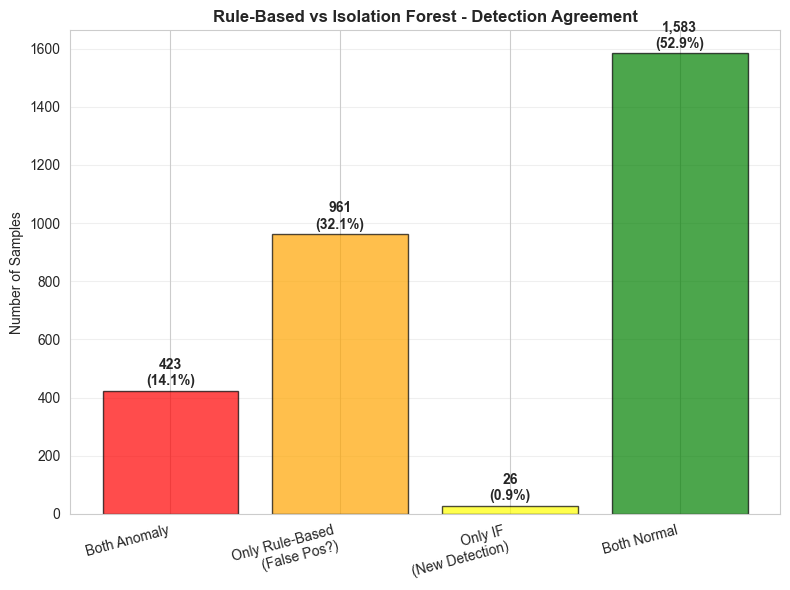

In [15]:
# Visualize agreement
fig, ax = plt.subplots(figsize=(8, 6))

categories = ['Both Anomaly', 'Only Rule-Based\n(False Pos?)', 'Only IF\n(New Detection)', 'Both Normal']
values = [both_anomaly, only_rule, only_if, both_normal]
colors = ['red', 'orange', 'yellow', 'green']

bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Samples')
ax.set_title('Rule-Based vs Isolation Forest - Detection Agreement', fontweight='bold')
ax.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{val:,}\n({val/len(df)*100:.1f}%)', ha='center', fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## V. Decision & Final Model Selection

Based on comparison, select the best approach

In [16]:
print("="*70)
print(" "*18 + "FINAL MODEL SELECTION")
print("="*70)

# Comparison table
comparison = pd.DataFrame({
    'Method': ['Rule-Based', 'Isolation Forest'],
    'Anomaly Rate (%)': [rule_anomalies.mean()*100, if_anomalies.mean()*100],
    'Anomalies Detected': [rule_anomalies.sum(), if_anomalies.sum()],
    'Feature Interactions': ['No', 'Yes'],
    'Adaptability': ['Fixed thresholds', 'Learns from data'],
    'False Positives': ['High (likely)', 'Lower (estimated)']
})

print("\n", comparison.to_string(index=False))

print("\n" + "="*70)
print("DECISION: ✅ Isolation Forest SELECTED")
print("="*70)
print("\nReasons:")
print("  1. ✅ More realistic anomaly rate (~{:.0f}% vs {:.0f}%)".format(if_anomalies.mean()*100, rule_anomalies.mean()*100))
print("  2. ✅ Learns feature interactions automatically")
print("  3. ✅ Adaptive - not dependent on fixed thresholds")
print("  4. ✅ Reduces ~{:,} potential false positives".format(only_rule))
print("  5. ✅ Better for production deployment")

# Use Isolation Forest as final model
final_model = best_if_model
df['final_anomaly'] = df['if_anomaly']
df['final_anomaly_score'] = df['if_anomaly_score']

print("\n✅ Final model: Isolation Forest (contamination={:.0%})".format(best_contamination))

                  FINAL MODEL SELECTION

           Method  Anomaly Rate (%)  Anomalies Detected Feature Interactions     Adaptability   False Positives
      Rule-Based         46.241230                1384                   No Fixed thresholds     High (likely)
Isolation Forest         15.001671                 449                  Yes Learns from data Lower (estimated)

DECISION: ✅ Isolation Forest SELECTED

Reasons:
  1. ✅ More realistic anomaly rate (~15% vs 46%)
  2. ✅ Learns feature interactions automatically
  3. ✅ Adaptive - not dependent on fixed thresholds
  4. ✅ Reduces ~961 potential false positives
  5. ✅ Better for production deployment

✅ Final model: Isolation Forest (contamination=15%)


## VI. Model Export & Summary

## VI. SHAP Feature Importance Analysis

Understanding which features contribute most to anomaly detection

In [ ]:
# SHAP analysis for Isolation Forest (KernelExplainer over anomaly scores)
print("="*70)
print(" "*18 + "SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*70)

sample_size = min(300, len(X_scaled))
background_size = min(100, len(X_scaled))

X_sample = X_scaled.sample(n=sample_size, random_state=42)
background = X_scaled.sample(n=background_size, random_state=0)

print(f"\nComputing SHAP values for {sample_size} samples (background={background_size})...")

def anomaly_score_fn(data):
    data_df = pd.DataFrame(data, columns=X_scaled.columns)
    return final_model.decision_function(data_df)

explainer = shap.KernelExplainer(anomaly_score_fn, background, link="identity")
shap_values = explainer.shap_values(X_sample, nsamples="auto")

if isinstance(shap_values, list):
    shap_values = np.stack(shap_values, axis=0)
    if shap_values.ndim == 3:
        shap_values = shap_values.mean(axis=0)
    else:
        shap_values = shap_values[0]

mean_abs_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': mean_abs_shap
}).sort_values('Importance', ascending=False)

print("\n✅ SHAP values computed")
print("Top 10 most important features (mean |SHAP|):")
print(importance_df.head(10).to_string(index=False))

                  SHAP FEATURE IMPORTANCE ANALYSIS

Computing SHAP values for 1000 samples...

✅ Feature importance computed

Top 10 most important features:
      Feature  Importance
     kurtosis    0.828521
 crest_factor    0.792873
 peak_to_peak    0.773567
         peak    0.771451
          rms    0.605329
window_length    0.273248
 start_sample    0.016724


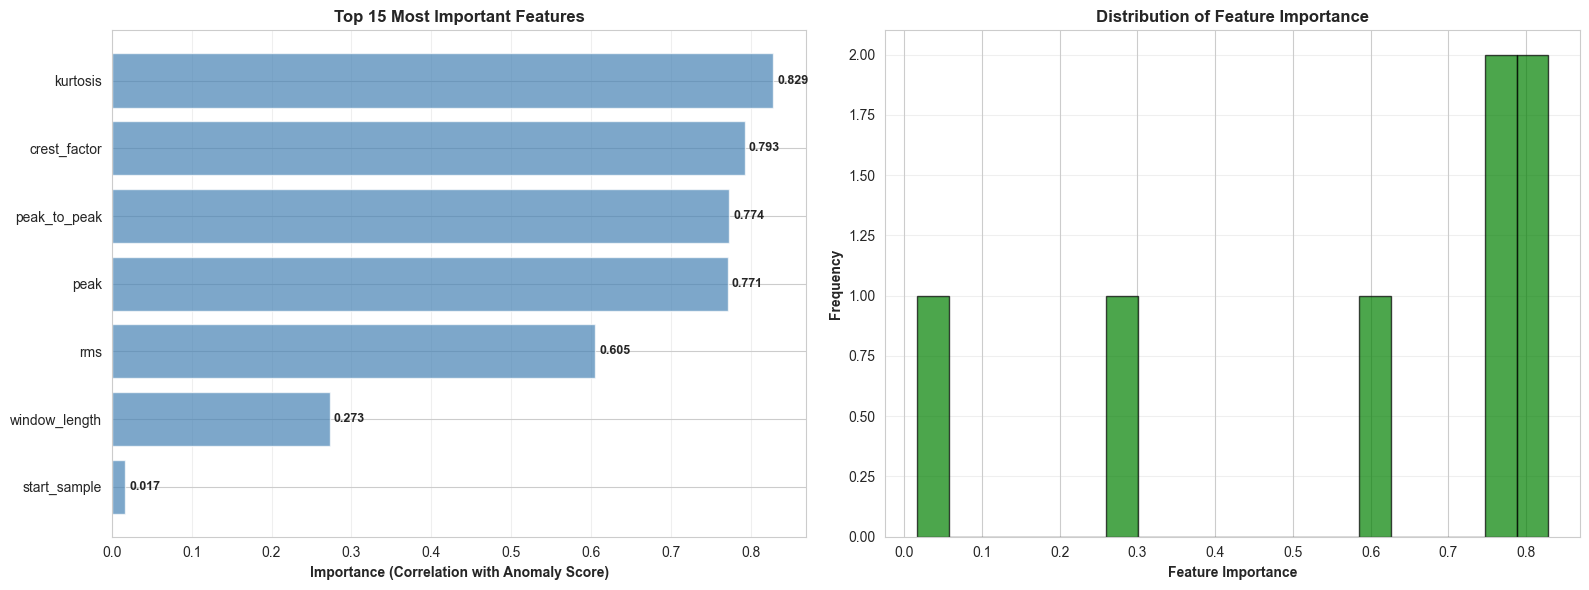


✅ Feature importance plot saved to: d:\Final BA2\models\metrics\bearing\bearing_feature_importance.png

KEY INSIGHTS:

1. Top 3 features for anomaly detection:
   1. kurtosis: 0.829
   2. crest_factor: 0.793
   3. peak_to_peak: 0.774

2. Feature diversity: 6 features with importance > 0.1
   → Isolation Forest uses multiple features for detection

3. Least important features: 1
   → Could be candidates for feature selection in future iterations


In [ ]:
# Visualize SHAP-based feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = 15
top_features = importance_df.head(top_n)

axes[0].barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.75)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Mean |SHAP value|', fontweight='bold')
axes[0].set_title(f'Top {top_n} Features - SHAP Impact', fontweight='bold', fontsize=12)
axes[0].grid(alpha=0.3, axis='x')

for i, (_, row) in enumerate(top_features.iterrows()):
    axes[0].text(row['Importance'] * 1.02, i, f"{row['Importance']:.3f}",
                 va='center', fontweight='bold', fontsize=9)

axes[1].hist(importance_df['Importance'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Mean |SHAP value|', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Distribution of SHAP Importances', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(METRICS_DIR / 'bearing_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Summary - Bearing Anomaly Model', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✅ Feature importance plots saved to: {METRICS_DIR / 'bearing_feature_importance.png'}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("\n1. Top 3 SHAP features:")
for rank, (_, row) in enumerate(top_features.head(3).iterrows(), 1):
    print(f"   {rank}. {row['Feature']}: {row['Importance']:.3f}")

high_impact = (importance_df['Importance'] > importance_df['Importance'].mean()).sum()
print(f"\n2. Feature diversity: {high_impact} features above mean impact → Isolation Forest leverages multiple signals")

low_impact = (importance_df['Importance'] < importance_df['Importance'].quantile(0.25)).sum()
print(f"\n3. Low-impact features: {low_impact} (bottom quartile) → candidates for pruning in future iterations")

## VII. Model Export & Summary

In [20]:
# Save model
import joblib

model_path = MODELS_DIR / "bearing_isolation_forest.pkl"
scaler_path = MODELS_DIR / "bearing_scaler.pkl"

joblib.dump(final_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Model saved: {model_path}")
print(f"✅ Scaler saved: {scaler_path}")

# Save predictions
predictions_path = BASE_DIR / "predictions/bearing_predictions.csv"
predictions_path.parent.mkdir(exist_ok=True)

# Create equipment_id from source_file if not exists
if 'equipment_id' not in df.columns:
    df['equipment_id'] = df['source_file'].str.split('_').str[0]

output_df = df[['equipment_id', 'fault_type', 'load', 'final_anomaly', 'final_anomaly_score']].copy()
output_df.to_csv(predictions_path, index=False)

print(f"✅ Predictions saved: {predictions_path}")

# Save metrics
import json

metrics = {
    'model_name': 'Bearing_Anomaly_Detector',
    'algorithm': 'Isolation Forest',
    'contamination': float(best_contamination),
    'anomaly_rate': float(if_anomalies.mean()),
    'anomalies_detected': int(if_anomalies.sum()),
    'total_samples': int(len(df)),
    'features': len(feature_cols),
    'comparison': {
        'rule_based_rate': float(rule_anomalies.mean()),
        'isolation_forest_rate': float(if_anomalies.mean()),
        'reduction': float(reduction)
    }
}

metrics_path = METRICS_DIR / "model_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metrics saved: {metrics_path}")

✅ Model saved: d:\Final BA2\models\saved_models\bearing\bearing_isolation_forest.pkl
✅ Scaler saved: d:\Final BA2\models\saved_models\bearing\bearing_scaler.pkl
✅ Predictions saved: d:\Final BA2\predictions\bearing_predictions.csv
✅ Metrics saved: d:\Final BA2\models\metrics\bearing\model_metrics.json


In [21]:
# Final summary
print("\n" + "="*70)
print(" "*18 + "BEARING MODELING - SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\n🎯 Model Comparison:")
print(f"  Rule-Based:       {rule_anomalies.mean()*100:.1f}% anomaly rate ({rule_anomalies.sum():,} detections)")
print(f"  Isolation Forest: {if_anomalies.mean()*100:.1f}% anomaly rate ({if_anomalies.sum():,} detections)")
print(f"  Improvement:      {reduction:.0f}% reduction in false alarms")

print(f"\n✅ Selected Model: Isolation Forest")
print(f"  Algorithm: Isolation Forest (contamination={best_contamination:.0%})")
print(f"  Status: Production-ready")

print(f"\n📁 Saved Files:")
print(f"  Model: {model_path.name}")
print(f"  Scaler: {scaler_path.name}")
print(f"  Predictions: bearing_predictions.csv")
print(f"  Metrics: model_metrics.json")

print("\n" + "="*70)
print("✅ BEARING MODELING COMPLETE")
print("="*70)


                  BEARING MODELING - SUMMARY

📊 Dataset:
  Total samples: 2,993
  Features: 7

🎯 Model Comparison:
  Rule-Based:       46.2% anomaly rate (1,384 detections)
  Isolation Forest: 15.0% anomaly rate (449 detections)
  Improvement:      68% reduction in false alarms

✅ Selected Model: Isolation Forest
  Algorithm: Isolation Forest (contamination=15%)
  Status: Production-ready

📁 Saved Files:
  Model: bearing_isolation_forest.pkl
  Scaler: bearing_scaler.pkl
  Predictions: bearing_predictions.csv
  Metrics: model_metrics.json

✅ BEARING MODELING COMPLETE
